# ImageNet VGG16 Model with Keras

This notebook demonstrates how to use the model agnostic Kernel SHAP algorithm to explain predictions from the VGG16 network in Keras.

In [1]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as pl
import numpy as np
import shap
from numpy.random import multivariate_normal


# load model data
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()
model = VGG16()

# load an image
file = "data/apple_strawberry.jpg"
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)

# segment the image so we don't have to explain every pixel
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)

Using TensorFlow backend.
/home/dslack/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dslack/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dslack/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dslack/.local/lib/python3.7/site-packages/tensorflow/python

ModuleNotFoundError: No module named 'shap'

In [2]:
# segment the image so with don't have to explain every pixel
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)

In [3]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [4]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values, shap_vars, calc_r = explainer.shap_values(np.ones((1,50)), nsamples=100, l1_reg="bic") # runs VGG16 1000 times


In [5]:
# get the top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

In [6]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

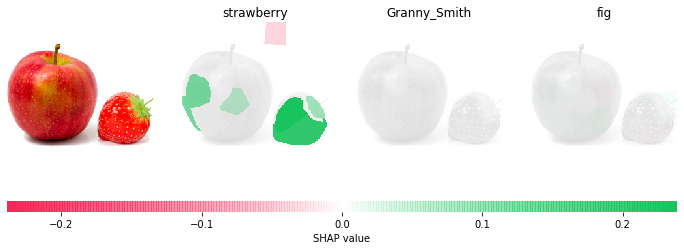

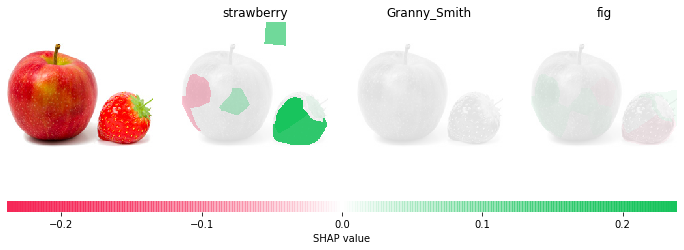

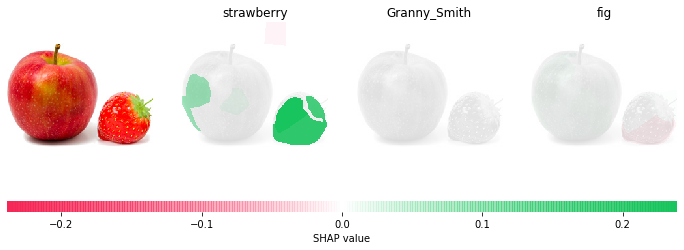

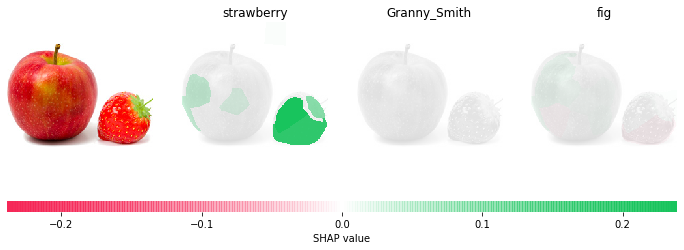

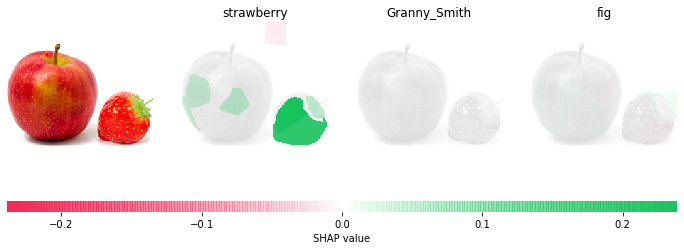

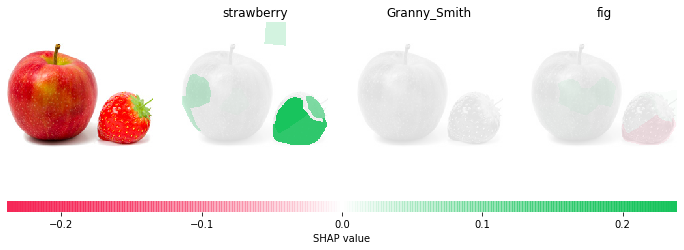

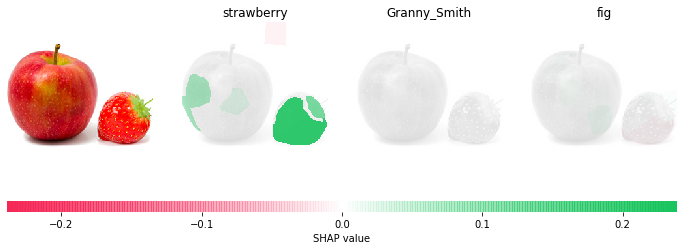

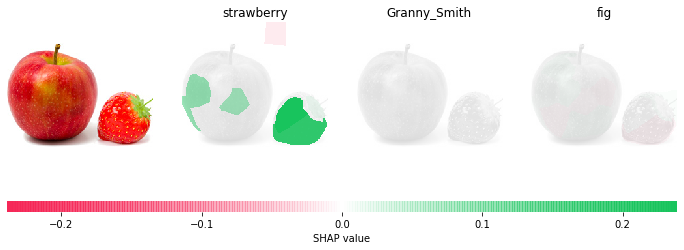

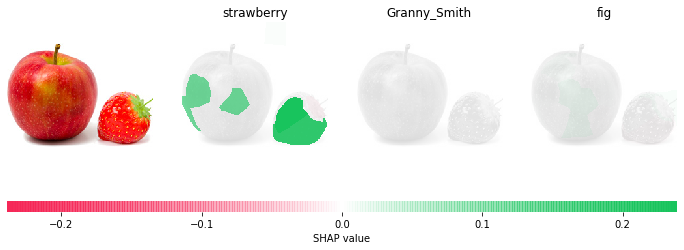

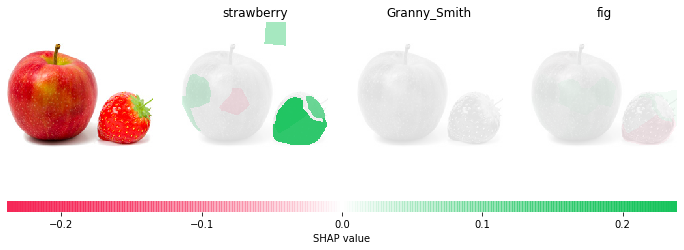

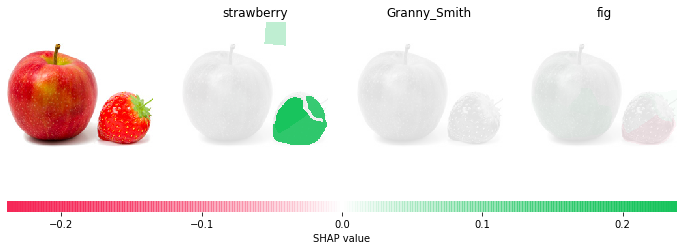

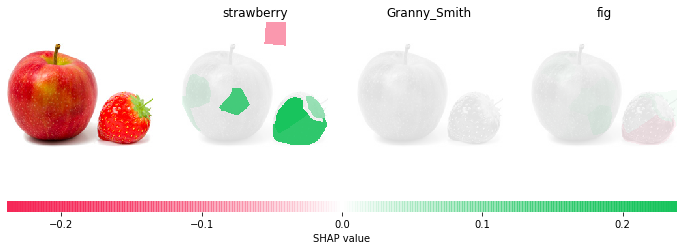

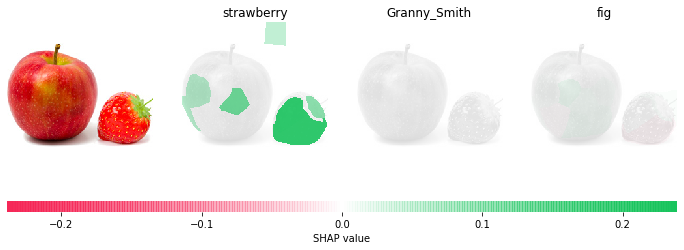

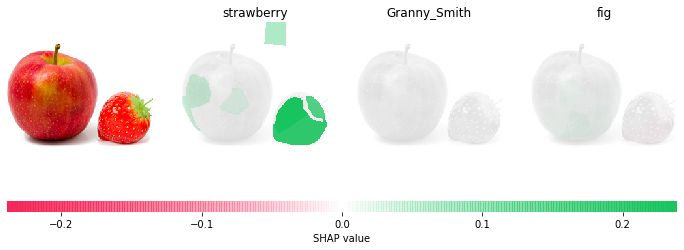

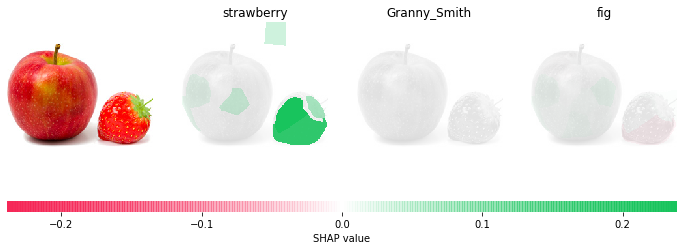

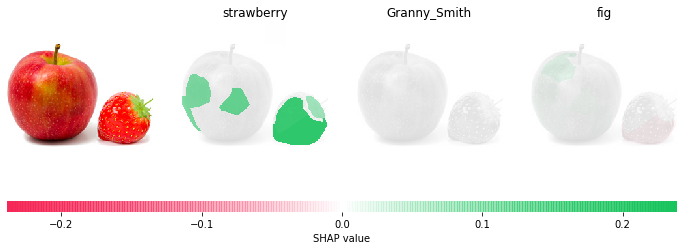

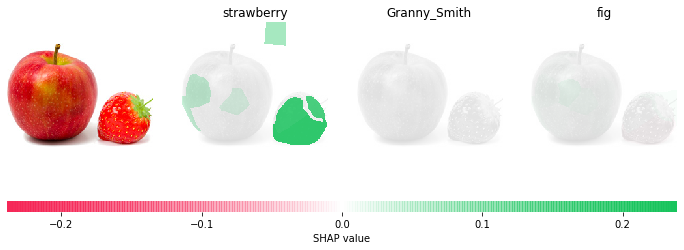

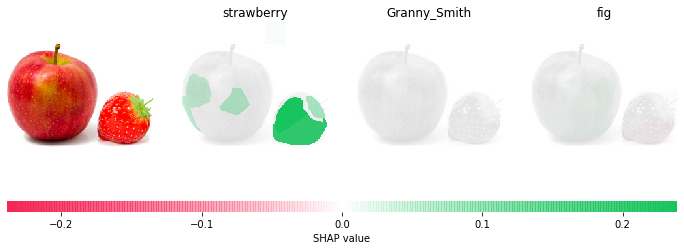

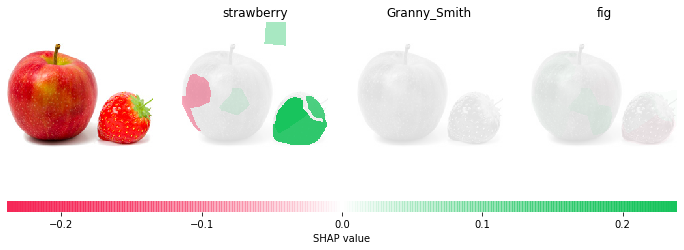

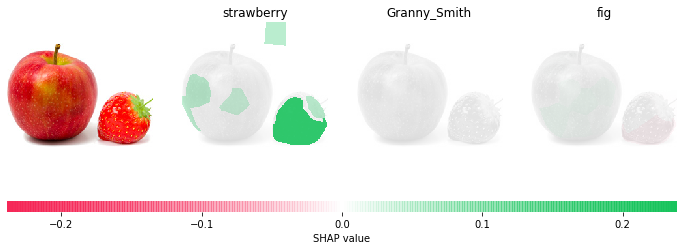

In [7]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
for ex in range(20):
    fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(12,4))
    inds = top_preds[0]
    axes[0].imshow(img)
    axes[0].axis('off')
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    for i in range(3):
        shap_means = shap_values[inds[i]][0]
        shap_variance = shap_vars[inds[i]]

        m = fill_segmentation(multivariate_normal(shap_means, shap_variance), segments_slic)
    #     m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
        axes[i+1].set_title(feature_names[str(inds[i])][1])
        axes[i+1].imshow(img.convert('LA'), alpha=0.15)
        im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
        axes[i+1].axis('off')
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)
    pl.savefig("samples/fig_{}".format(ex))

In [8]:
print (shap_values[0])

[[ 0.00000000e+00 -3.18153183e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.92731619e-05
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.51158371e-05 -1.41217840e-05 -1.23099228e-05
  -1.14657986e-05 -2.15800287e-05  0.00000000e+00  0.00000000e+00
  -2.57855656e-05  0.00000000e+00  0.00000000e+00 -2.31672721e-05
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.32262016e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.76272341e-05  0.00000000e+00  0.00000000e+00 -2.21603673e-05
   0.00000000e+00  0.00000000e+00]]


In [9]:
print (inds)

[949 948 952 950 957 951 954 470 828 644 928 700 868 953 929 582 790 945
 956 773 927 943 989 522 725 968 969 509 769 574 883 415 923 767 641 572
 328 990 647 584 728 629 659 677 519 711 631 910 855 419 738 692 600 588
 845 809 849 463 931 804 679 924 939 966 944 778 960 942 503 398 599 719
 936 712 911 737 478 551 748 666 772 709 988 838 937 940 680 504 941 723
 530 992 543 604 930 696 947 955 505 899 925 409 813 852 938 438 310 793
 859 619 618 846 987 664 109 455 808 946   8   7 429 417 934 961 635 467
 999 533 731 499 922 658 567 521 448 650 933 901 885 898 971  78 850 549
 722 879 607 892 684 577 716 782 585 962 784 710 435 605 674 301 489 996
 729 746 791 496 668 926 916 907 998 721 459 113 428 995 816 516 754  90
 985 487 515 506 959 406 433 967 720 997 112 823 333 636 760 626 114 452
 422 443 446 283 544 798 464 783 580 542 840 835 876 613 134 896 964 130
 494 921 860 488 918  12 587  75 646 886 507 688 108 903 185 532 935 318
 958 682 492 591 136 747 673 325 851 122 606 762 64